## A Behavior-based Controller for a Mobile Robot Tracking a Moving Target in Multi-obstacles Environment


william.martins@ee.ufcg.edu.br 28/02/2024

In [1]:
from numpy import cos, sin, pi, sqrt, arctan2
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from plot_result import plot_sim_result

<img src="figures/diagrams/body_global_frame.png" width=470>

These problem involves the tracking of a moving target with some velocity $v_T$ and orientation $\theta_T$ along the z-plane in global frame with origin \<O\>.

The kinematics equations based on diagram in term of the robot's linear velocity and orientation:

\begin{bmatrix*}
\dot{x} = v\cos\theta \\
\dot{y} = v\sin\theta \\
\dot{\theta} = w \\
\end{bmatrix*}

And, the distance between robot for each axis component could be expressed as:
\begin{bmatrix*}
D\cos\phi = x_T - x \\
D\sin\phi = y_T - y \\
\end{bmatrix*}

The relative angular relations between the robot orientation and target. Also, the linear distance error and angular based on desired set point is:
\begin{bmatrix*}
\alpha = \theta - \phi  & e_D = D_d - D\\
\beta = \theta_T - \phi & e_\alpha = \alpha_D - \alpha\\
\end{bmatrix*}

The close-loop proposed by Benbouabdallah involve others block that will not be coveraged in this work, the only problem that will be target is the Tracking Target (TT) control.

<div align="center">
<img src="figures/diagrams/closed_loop_diagram.png" width=470>
</div>

But the kinematics equations doesn't provide a set of linear functions, then control must be modelled using the Lyapunov Framework that gives a path to project a non-linear controller that stabilize the system. The first step is to provide a candidate Lyapunov Function, the simple one is the quadratic form of closed-loop errors

\begin{bmatrix*}
V_1 = 0.5e_D^2       & \dot{V_1} = e_D\dot{e_D}             \\
V_2 = 0.5e_\alpha^2  & \dot{V_2} = e_\alpha\dot{e_\alpha}    \\
V = V_1 + V_2        & \dot{V} = \dot{V_1} + \dot{V_2}
\end{bmatrix*}

By the first derivative terms, the kinematics equations, and close-loop erros by considering that the robot must be aligned to target:
\begin{matrix}
\dot{V_1} = -e_D(v_T\cos\beta - v\cos\alpha) \\
\dot{V_2} = -\alpha(v_T/D\sin\beta - v/D\sin\alpha - w)
\end{matrix}

If Lyapunov function decreases for any state, the system will be exponential stable. So defining v, w so that $\dot{V_1} \le 0$ and $\dot{V_2} \le 0$:

\begin{matrix}
v = v_T\cos\beta/\cos\alpha - K_ve_d\cos\alpha & w = -K_w\alpha - \frac{v}{D}\sin\alpha + \frac{v_T}{D}\sin\beta
\end{matrix}

applying the velocities in Lyapunov equations, gives:

\begin{matrix}
\dot{V_1} = - K_ve^2\cos^2\alpha \le 0  & \dot{V_2} = - K_w\alpha^2 \le 0 & K_w, K_v > 0
\end{matrix}

So the TT control law is give by:
\begin{equation*}
\begin{bmatrix}
v \\ w
\end{bmatrix}=
\begin{bmatrix}
v_T\cos\beta/\cos\alpha - K_ve_d\cos\alpha \\
-K_w\alpha - \frac{v}{D}\sin\alpha + \frac{v_T}{D}\sin\beta
\end{bmatrix}
\end{equation*}

The following system, computes the distance using the expressions obtained previously and gives a way to obtain the robot pose in inertial frame directly.

In [2]:
def target_tracking_block(t, state, D, beta, alpha, vt):
    """Compute Lyapunov Control Law
        args:
        state = [e_d, e_alpha]
        pose: tuple of (robot poses array, target poses array)
    """
    global Kv, Kw
    e_d, e_alpha = state

    # if((abs(abs(alpha) - pi)) > 0.01):    
    v = vt*cos(beta)/cos(alpha) - Kv*e_d*cos(alpha)
    # else:
        # v = -vt*sin(beta)
    v = min(abs(v), 1.2) # just depends of TT controller
    Vf = v
    w = -Kw*alpha - Vf/D*sin(alpha) + vt/D*sin(beta) 

    return v, w

def compute_distance(robot_pos, target_pos):
    D = sqrt((robot_pos[0]-target_pos[0])**2 + (robot_pos[1] - target_pos[1])**2)
    # orientation related to target
    phi = arctan2(target_pos[1]-robot_pos[1], target_pos[0]-robot_pos[0])
    return D, phi

def closed_loop(t, state,  target_pos, e_ref = [0, 0]):
    x_r, y_r, theta_r, v_r, x_t, y_t = state

    _, v_t = target_pos

    D, phi = compute_distance([x_r, y_r], [x_t, y_t])

    dx_t, dy_t, theta_t = target_velocity(t)
    vt = 0.5*sqrt((dx_t*cos(theta_t))**2 + (dy_t*sin(theta_t))**2)

    beta  = theta_t - phi  # target_pos[2] = theta_t
    alpha = theta_r - phi  # robot_pos[2]  = theta

    e_d = e_ref[0] - D
    e_alpha = 0 - alpha

    v, w = target_tracking_block(t, state=[e_d, e_alpha], D=D, 
                                beta=beta, alpha=alpha, vt=vt)
    # print(v, w, theta_t)
    # Robotic Kinematic
    dx = v*cos(phi)
    dy = v*sin(phi)
    dtheta = w

    return [dx, dy, dtheta, v, dx_t, dy_t]

### Target trajectory

In [3]:
def circular_trajectory(t):
    """ returns the target trajectory variation in x, y and the orientation"""
    if t > 10:
        return [0, 0, 0]
    return [-sin(t), cos(t), arctan2(sin(t), cos(t))]

## Simulation

(2, 156) (2, 156)


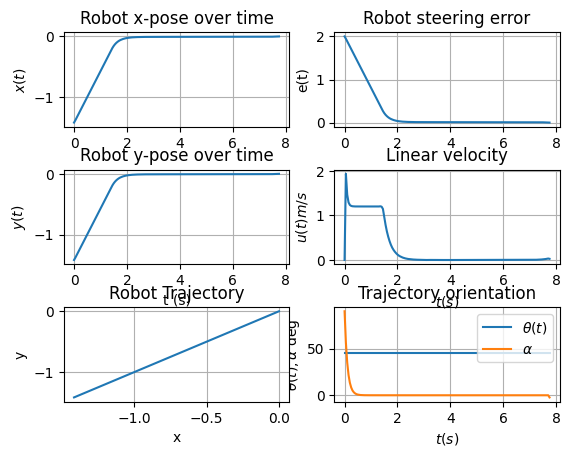

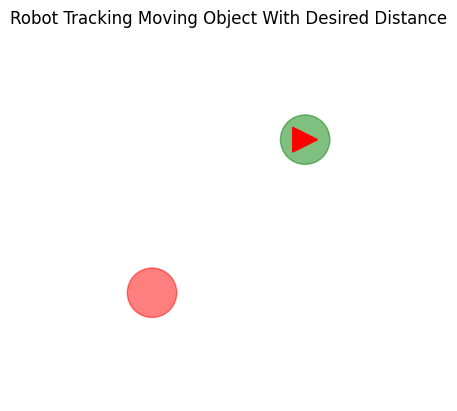

In [4]:
target_velocity = lambda t: [0, 0, 0]
# target_velocity = circular_trajectory

target = [0, 0]
# robot: x, y, orientation, initial velocity
robot = [-1*sqrt(2), -1*sqrt(2), pi, 0,
        0, 0] # target x, y

t = np.arange(0, 15, 50e-3)
Kw = 1.49*6
Kv = 2.07*2
sol = solve_ivp(closed_loop, t_span=[t[0], t[-1]], 
                t_eval=t, y0=robot, args=(target, [0.01, 0]))


# compute error
xy = sol.y[0:2]     # x, y
theta = sol.y[2]    # theta
goal = sol.y[4:]    # x, y
print(goal.shape, xy.shape)

D, phi = compute_distance(xy, goal)
alpha = theta - phi

# plt.plot(goal[0], goal[1]), plt.show()
plot_sim_result(sol.t, [D, alpha, phi],
                [xy[0], xy[1], theta],
                goal=goal, save_anim=True)
plt.show()